# Import libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import iqr
from scipy.stats import zscore

from utils import eda_train_path

# Load datasets

In [2]:
train_df = pd.read_csv(eda_train_path)

# Funcs

## Функции для поиска выбросов

In [3]:
def detect_outliers_iqr(df, column):
    """
    Выявляет выбросы с помощью IQR (межквартильного размаха).
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr_value = iqr(df[column])  # Готовая функция
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    return (df[column] < lower_bound) | (df[column] > upper_bound)

In [4]:
def detect_outliers_zscore(df, column, threshold=3):
    """
    Выявляет выбросы с помощью Z-score.
    """
    return abs(zscore(df[column])) > threshold  # Готовая функция

In [5]:
def detect_outliers_percentile(df, column, percentile=95):
    """
    Выявляет выбросы на основе percentiles (например, 95%).
    """
    threshold = np.percentile(df[column], percentile)
    return df[column] > threshold

In [6]:
def detect_outliers(df, column):
    """
    Вычисляет выбросы по разным методам и возвращает их статистику.
    """
    methods = {
        "IQR": detect_outliers_iqr(df, column),
        "Z-score": detect_outliers_zscore(df, column),
        "95th Percentile": detect_outliers_percentile(df, column)
    }

    results = {method: outliers.sum() for method, outliers in methods.items()}

    # Вывод результатов
    print(f"Outlier detection results for {column}:")
    for method, count in results.items():
        percentage = (count / len(df)) * 100
        print(f"{method}: {count} выбросов ({percentage:.2f}%)")

    return methods  # Возвращаем словарь для дальнейшего анализа

## Функция для визуализации выбросов

In [7]:
def plot_outliers_analysis(df, column, methods):
    """
    Строит 6 графиков, располагая их один под другим:
    1. Boxplot исходных данных 
    2. Boxplot с ограниченным масштабом (без экстремальных выбросов)
    3. Гистограмму распределения
    4. Гистограмму с логарифмической шкалой
    5. KDE-плот с выделением выбросов разными методами
    6. Гистограмму после удаления выбросов (по IQR)
    """
    fig, axes = plt.subplots(6, 1, figsize=(12, 36))  # Один график в строке
    
    # Boxplot для всего диапазона значений
    sns.boxplot(x=df[column], ax=axes[0])
    axes[0].set_title(f"Boxplot of {column}")

    # Boxplot с ограничением (детализированное отображение)
    sns.boxplot(x=df[column], ax=axes[1])
    axes[1].set_xlim(df[column].quantile(0.01), df[column].quantile(0.99))
    axes[1].set_title(f"Boxplot (zoomed-in) of {column}")

    # Гистограмма распределения
    sns.histplot(df[column], bins=50, kde=True, ax=axes[2])
    axes[2].set_title(f"Histogram of {column}")

    # Гистограмма с логарифмической шкалой
    sns.histplot(df[column], bins=50, kde=True, ax=axes[3])
    axes[3].set_xscale("log")
    axes[3].set_title(f"Histogram (log scale) of {column}")

    # KDE-график с выделением выбросов разными методами
    sns.kdeplot(df[column][~methods["IQR"]], label="Non-outliers (IQR)", ax=axes[4])
    sns.kdeplot(df[column][methods["IQR"]], label="Outliers (IQR)", linestyle="dashed", ax=axes[4])

    sns.kdeplot(df[column][~methods["Z-score"]], label="Non-outliers (Z-score)", ax=axes[4])
    sns.kdeplot(df[column][methods["Z-score"]], label="Outliers (Z-score)", linestyle="dotted", ax=axes[4])

    sns.kdeplot(df[column][~methods["95th Percentile"]], label="Non-outliers (95th Percentile)", ax=axes[4])
    sns.kdeplot(df[column][methods["95th Percentile"]], label="Outliers (95th Percentile)", linestyle="dashdot", ax=axes[4])

    axes[4].legend()
    axes[4].set_title(f"Distribution of {column} with Outliers")

    # Гистограмма после удаления выбросов по IQR
    cleaned_data = df[column][~methods["IQR"]]
    sns.histplot(cleaned_data, bins=50, kde=True, ax=axes[5])
    axes[5].set_title(f"Histogram of {column} (without IQR outliers)")

    plt.tight_layout()
    plt.show()

## Проверка корректности логарифмирования

In [8]:
def check_log_transform(df, column):
    if (df[column] == 0).sum() > 0:
        print(f"Warning: {column} contains zero values, which may cause issues in log transformation.")
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    sns.histplot(df[column], bins=100, kde=True, ax=axes[0])
    axes[0].set_title(f"Original distribution of {column}")

    sns.histplot(np.log1p(df[column]), bins=100, kde=True, ax=axes[1])
    axes[1].set_title(f"Log-transformed distribution of {column}")

    plt.tight_layout()
    plt.show()

# valid_miles

## Valid miles vs. Log Valid miles

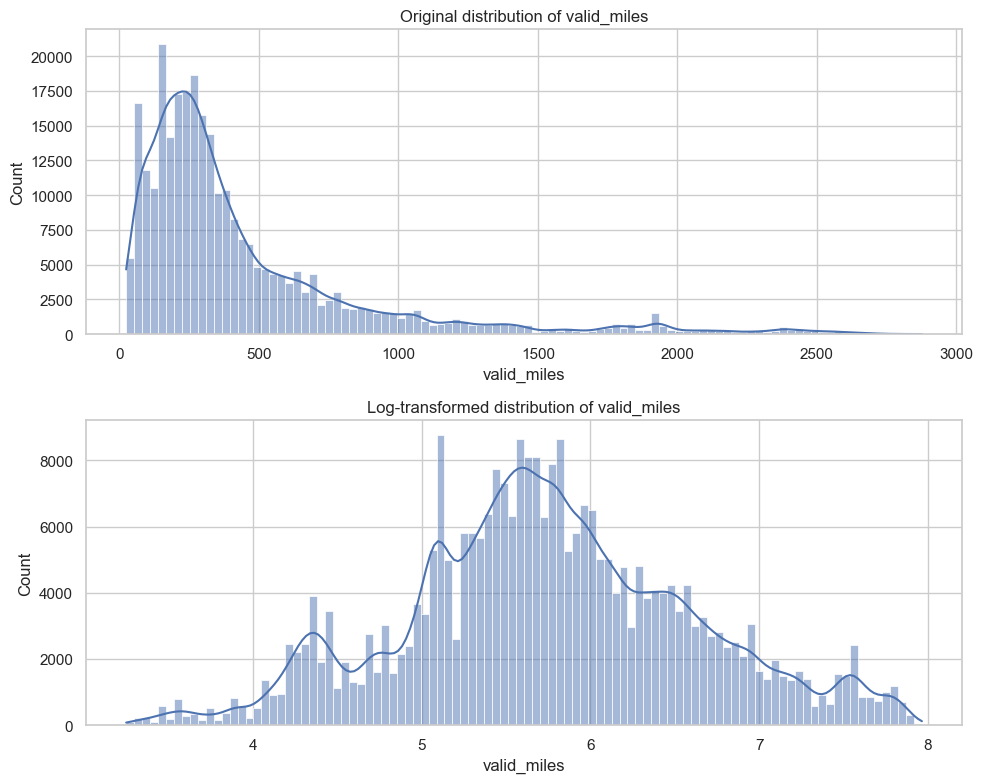

In [9]:
check_log_transform(train_df, "valid_miles")

## Добавить логарифм valid_miles


| Вариант | Плюсы | Минусы |
|------------------------------------------------|------------------------------------------------------------------------------------------|----------------------------------------------------------------|
| **Оставить `valid_miles` и `log_valid_miles`** | Модель может использовать обе информации.<br>Можно проверить важность обоих признаков. | Увеличение размерности данных.<br>Возможна избыточность. |
| **Оставить только `log_valid_miles`**| Убираем лишнюю корреляцию.<br>Простая интерпретация. | Если логарифм не улучшит модель, потеряем полезную информацию. |

- На первом этапе оставляем оба (valid_miles и log_valid_miles).
- После проверки важности признаков (feature importance) можно удалить valid_miles, если log_valid_miles окажется лучше.

In [10]:
train_df["log_valid_miles"] = np.log1p(train_df["valid_miles"])  # log1p безопаснее log

Что показывает график?
- При малых значениях log(valid_miles) (≈ 4–5) rate варьируется от 1 до 250, что говорит о высокой дисперсии.
- При увеличении log(valid_miles) (5+) rate стабилизируется и остается близким к нулю.
- Большинство значений log(valid_miles) лежат в диапазоне 4–7, что соответствует от 50 до 1000 миль.
- Логарифм valid_miles делает зависимость rate более плавной, что важно для линейных моделей.
- Высокая дисперсия при малых значениях valid_miles говорит о возможном влиянии других факторов (например, transport_type или origin_kma).
- Добавляем log(valid_miles) в модель.

# weight

## Weight vs. Log Weight

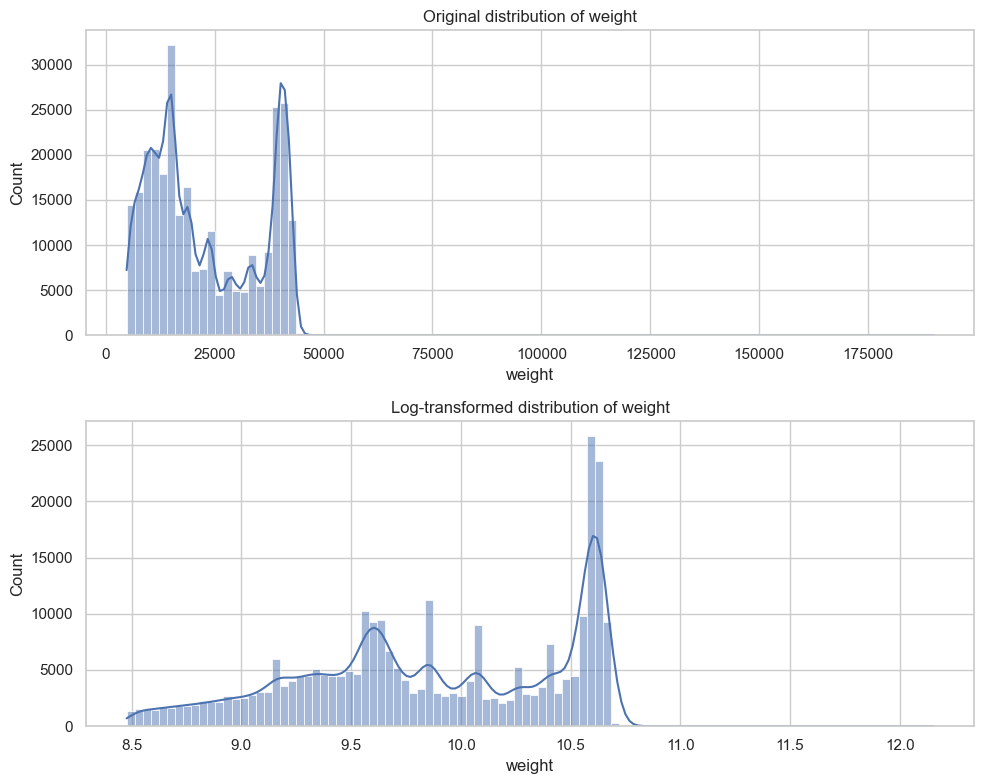

In [11]:
check_log_transform(train_df, "weight")

## Добавить логарифм weight

In [12]:
train_df["log_weight"] = np.log1p(train_df["weight"])  # log1p(0) = 0, безопаснее log

# Rate

In [13]:
outliers_dict = detect_outliers(train_df, "rate")

Outlier detection results for rate:
IQR: 14649 выбросов (5.12%)
Z-score: 4726 выбросов (1.65%)
95th Percentile: 14314 выбросов (5.00%)


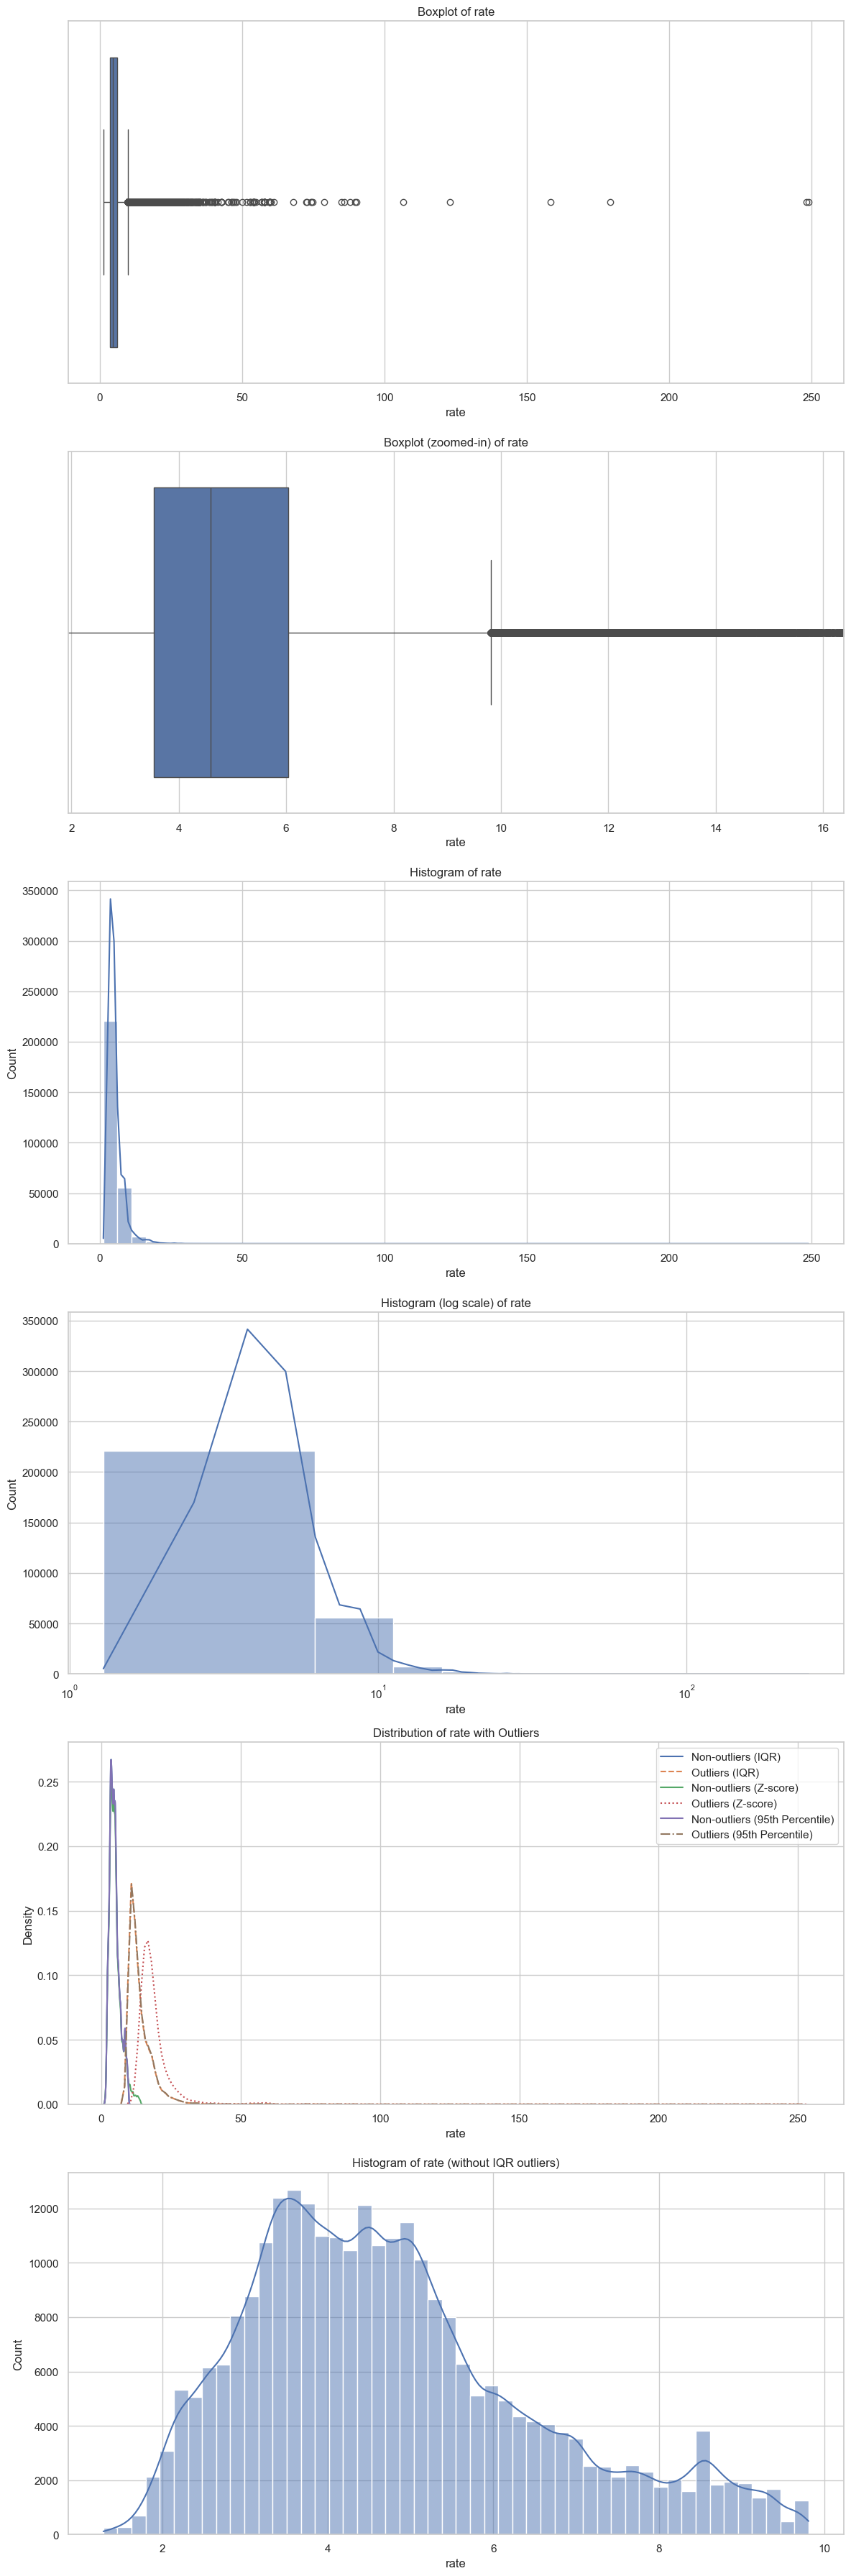

In [14]:
plot_outliers_analysis(train_df, "rate", outliers_dict)

**Общие наблюдения**
- **Выбросы выше 10**: 95-й перцентиль = 9.88, максимум = 248.97.
- **Большинство значений rate сосредоточено между 3 и 9**.
- **Сильная асимметрия распределения**: длинный правый хвост.
- **Методы обнаружения выбросов (IQR, Z-score, 95-й перцентиль) дали схожие результаты**:
    - **IQR**: 5.12% выбросов (rate > 9.88).
    - **Z-score**: 1.65% выбросов (более строгий).
    - **95-й перцентиль**: 5.00% выбросов.

**Выводы по графикам**
1. **Boxplot показывает явные выбросы выше 10, при этом подавляющее большинство значений ниже 9**.
2. **Гистограмма подтверждает скошенность вправо**: редкие, но высокие значения rate.
3. **Логарифмирование помогает нормализовать распределение**, делая данные более удобными для анализа.
4. **После удаления выбросов по IQR распределение становится более плавным и информативным**.
5. **Выбросы могут не быть случайными**, их стоит дополнительно исследовать.

**Что делать дальше?**
1. **Проверить, связаны ли высокие rate с конкретными KMA** (откуда и куда идет перевозка).
2. **Анализ rate по transport_type** – возможно, некоторые типы транспорта дороже.
3. **Проверить зависимость выбросов от valid_miles и weight** – увеличенные тарифы могут быть обусловлены особенностями груза или дальностью маршрута.
4. **Проверить влияние праздничных и особых дней** – например, повышенные тарифы на выходных или в праздничные периоды.
5. **Убедиться, что логарифмирование не ведет к потере данных** – проверить, нет ли значений rate = 0, так как log(0) не определен.

## Анализ выбросов по KMA

In [15]:
def analyze_rate_by_kma(df):
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Средний rate по origin_kma
    kma_avg_rate = df.groupby("origin_kma")["rate"].mean().sort_values()
    sns.barplot(x=kma_avg_rate.index, y=kma_avg_rate.values, ax=axes[0])
    axes[0].set_xticks(range(len(kma_avg_rate.index)))  # Добавляем явные ticks
    axes[0].set_xticklabels(kma_avg_rate.index, rotation=90)
    axes[0].set_title("Average rate by origin_kma")

    # Средний rate по destination_kma
    kma_avg_rate_dest = df.groupby("destination_kma")["rate"].mean().sort_values()
    sns.barplot(x=kma_avg_rate_dest.index, y=kma_avg_rate_dest.values, ax=axes[1])
    axes[1].set_xticks(range(len(kma_avg_rate_dest.index)))  # Добавляем явные ticks
    axes[1].set_xticklabels(kma_avg_rate_dest.index, rotation=90)
    axes[1].set_title("Average rate by destination_kma")

    plt.tight_layout()
    plt.show()

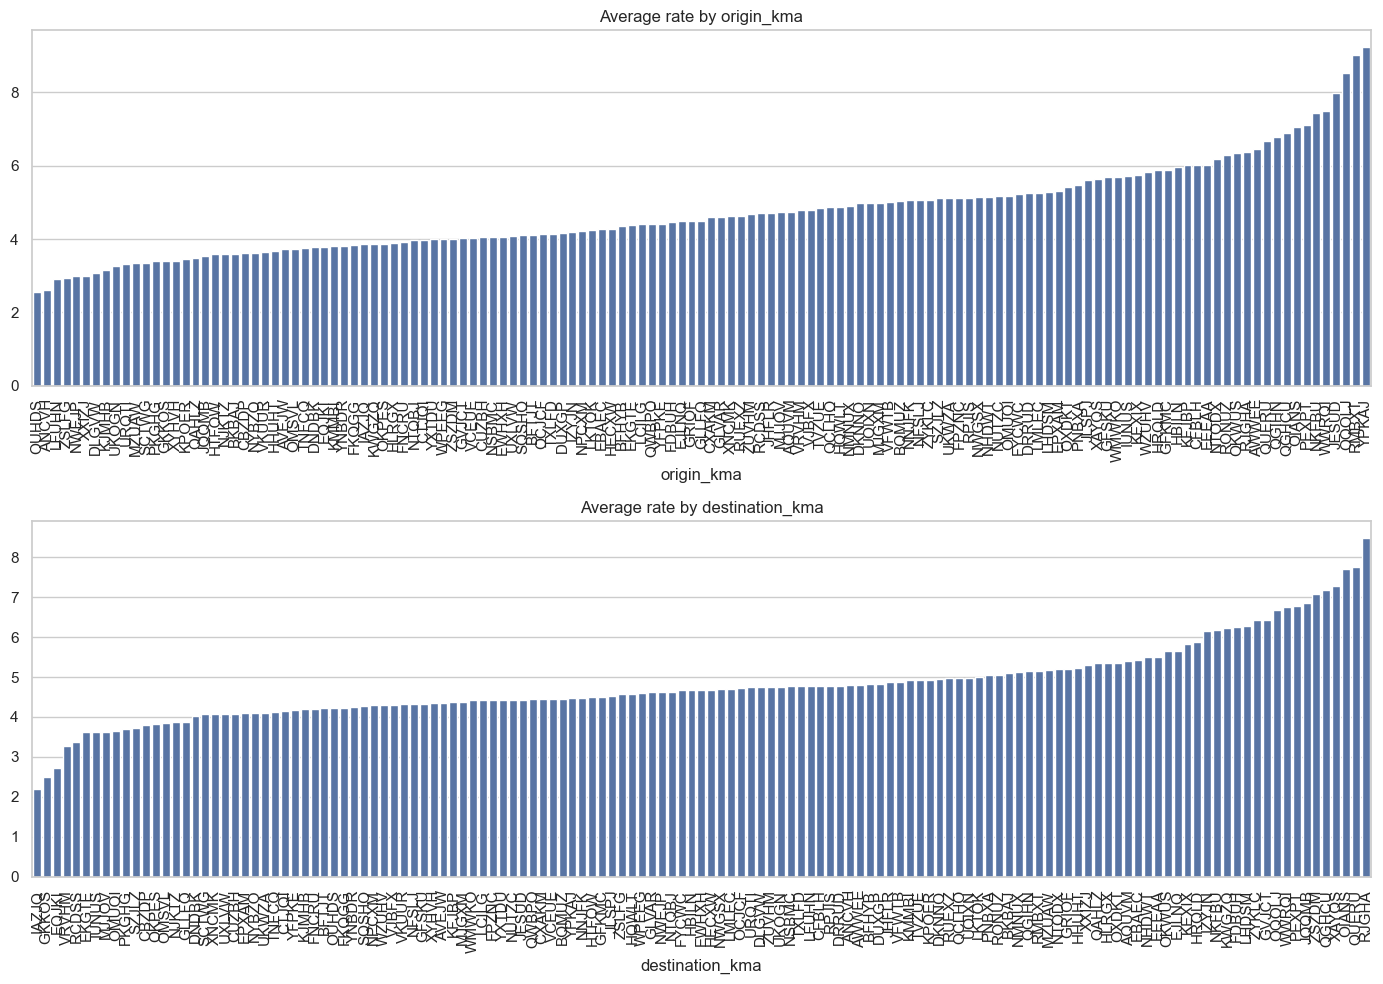

In [16]:
analyze_rate_by_kma(train_df)

## Анализ выбросов по transport_type

In [17]:
def analyze_rate_by_transport_type(df):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df["transport_type"], y=df["rate"])
    plt.title("Boxplot of rate by transport_type")
    plt.show()

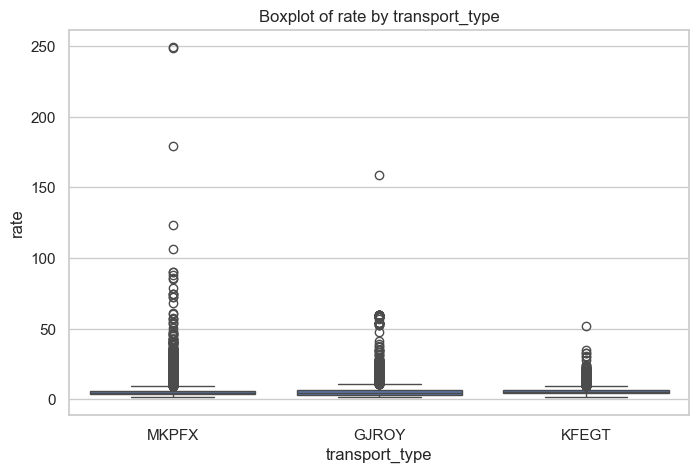

In [18]:
analyze_rate_by_transport_type(train_df)

## Анализ выбросов по valid_miles и weight

In [19]:
def analyze_rate_by_numeric_factors(df):
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    sns.scatterplot(x=df["valid_miles"], y=df["rate"], ax=axes[0])
    axes[0].set_title("Scatter plot of rate vs valid_miles")

    sns.scatterplot(x=df["weight"], y=df["rate"], ax=axes[1])
    axes[1].set_title("Scatter plot of rate vs weight")

    plt.tight_layout()
    plt.show()

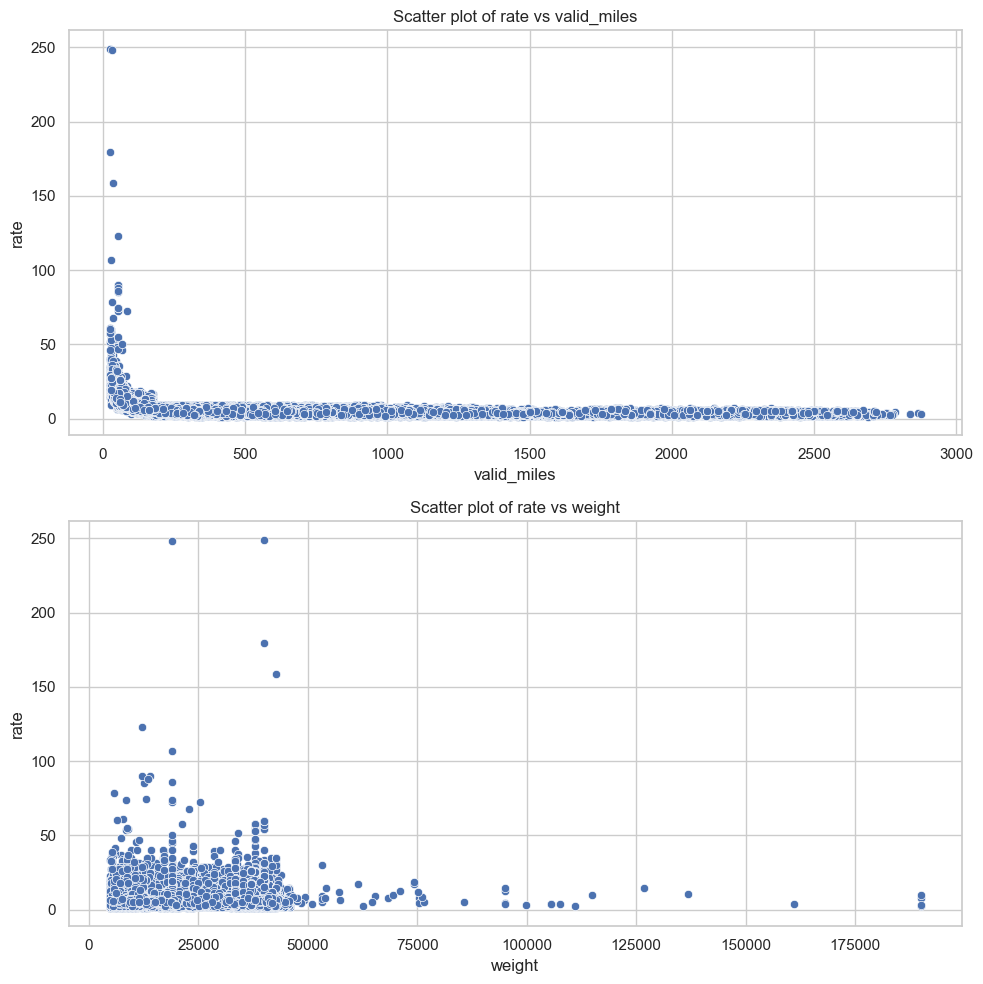

In [20]:
analyze_rate_by_numeric_factors(train_df)

## Анализ выбросов по праздничным дням

In [21]:
def analyze_rate_by_holidays(df, holiday_list):
    # Убеждаемся, что pickup_date в datetime формате
    if not np.issubdtype(df["pickup_date"].dtype, np.datetime64):
        df["pickup_date"] = pd.to_datetime(df["pickup_date"])
    
    # Преобразуем holiday_list в datetime формат
    holiday_dates = pd.to_datetime(holiday_list).date

    # Добавляем признак праздника
    df["is_holiday"] = df["pickup_date"].dt.date.isin(holiday_dates)

    # Визуализация
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df["is_holiday"], y=df["rate"])
    plt.xticks([0, 1], ["Non-Holiday", "Holiday"])
    plt.title("Boxplot of rate by Holiday")
    plt.show()

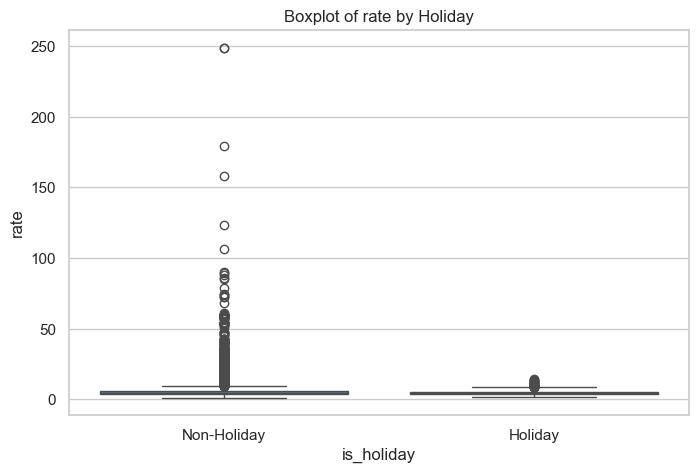

In [22]:
holidays = ["2021-01-01", "2021-07-04", "2021-12-25"]  # Пример праздничных дней
analyze_rate_by_holidays(train_df, holidays)

## Проверка топ-KMA с самыми высокими значениями rate

In [23]:
def analyze_top_kma(df):
    top_kma = df.groupby("origin_kma")["rate"].mean().nlargest(10)
    bottom_kma = df.groupby("origin_kma")["rate"].mean().nsmallest(10)

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    sns.barplot(x=top_kma.index, y=top_kma.values, ax=axes[0])
    axes[0].set_title("Top 10 origin_kma with highest rate")
    axes[0].set_xlabel("origin_kma")
    axes[0].set_ylabel("Average Rate")
    axes[0].tick_params(axis="x", rotation=90)

    sns.barplot(x=bottom_kma.index, y=bottom_kma.values, ax=axes[1])
    axes[1].set_title("Top 10 origin_kma with lowest rate")
    axes[1].set_xlabel("origin_kma")
    axes[1].set_ylabel("Average Rate")
    axes[1].tick_params(axis="x", rotation=90)

    plt.tight_layout()
    plt.show()

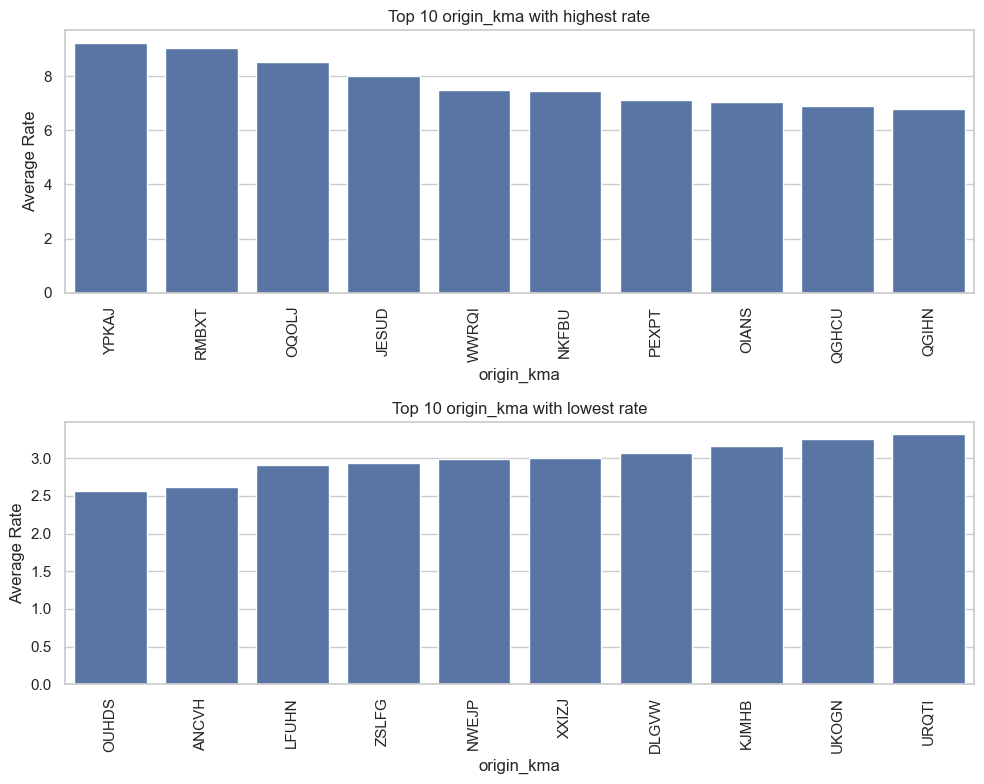

In [24]:
analyze_top_kma(train_df)

## Анализ зависимости rate от сочетания origin_kma и destination_kma

In [25]:
def analyze_rate_by_kma_combination(df):
    kma_combinations = df.groupby(["origin_kma", "destination_kma"])["rate"].mean().reset_index()
    kma_combinations = kma_combinations.pivot(columns="origin_kma", index="destination_kma", values="rate")

    plt.figure(figsize=(15, 14))
    sns.heatmap(kma_combinations, cmap="coolwarm", annot=False, linewidths=0.5)
    plt.xlabel("Destination KMA")
    plt.ylabel("Origin KMA")
    plt.title("Average rate by origin-destination KMA combination")
    plt.show()

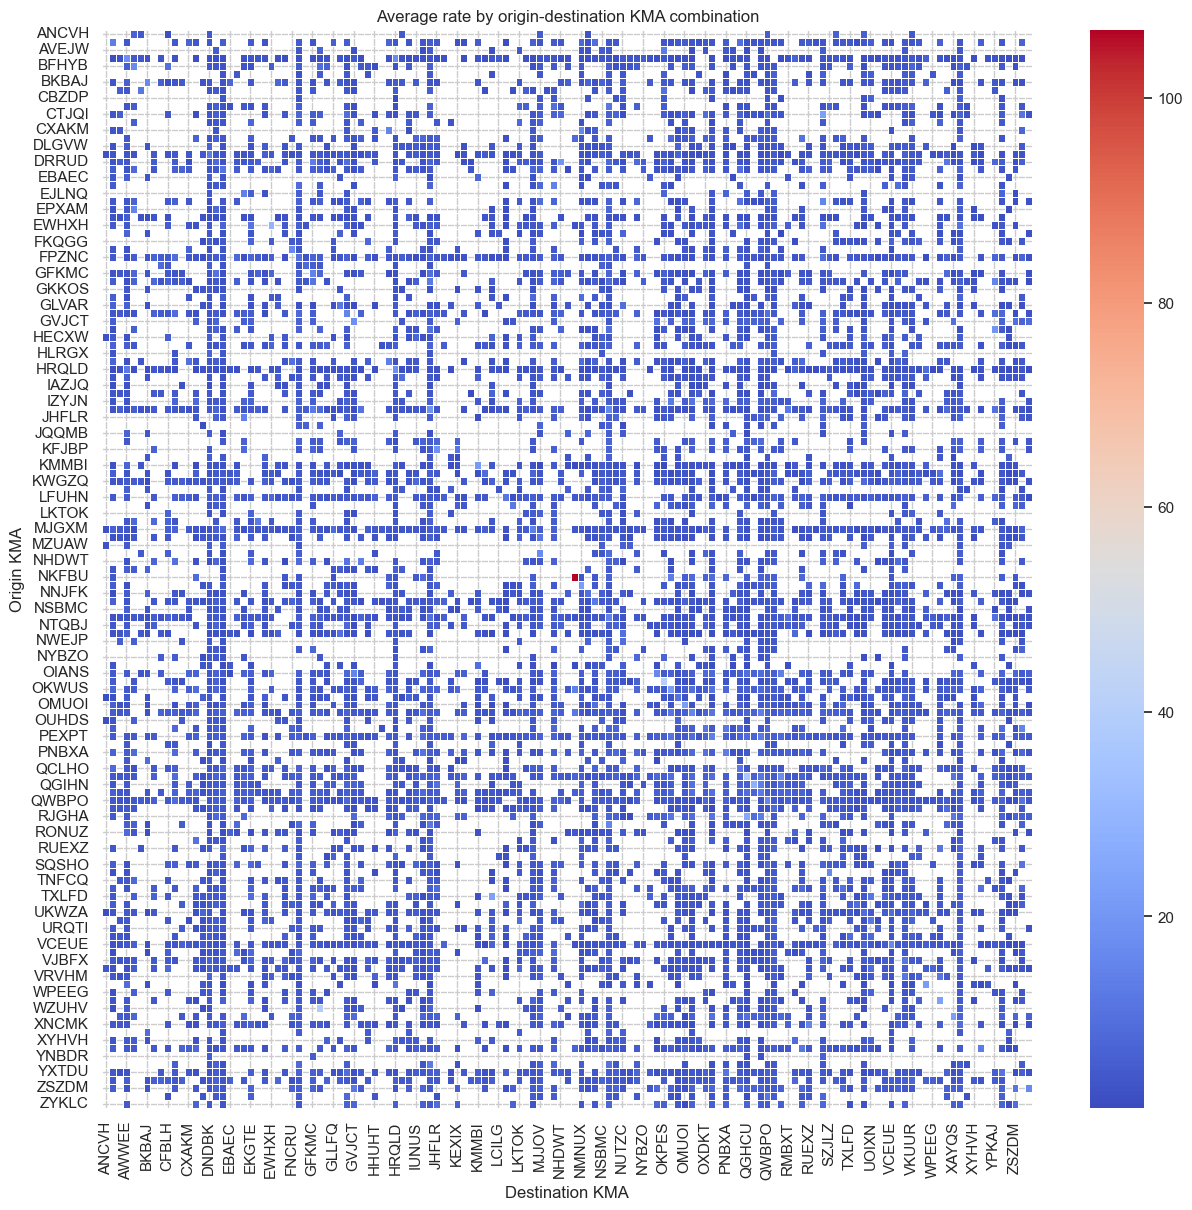

In [26]:
analyze_rate_by_kma_combination(train_df)

In [27]:
## Анализ выбросов valid_miles и weight

In [28]:
def analyze_outliers_valid_miles_weight(df):
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))

    # Boxplot valid_miles
    sns.boxplot(x=df["valid_miles"], ax=axes[0])
    axes[0].set_title("Boxplot of valid_miles")

    # Histogram valid_miles
    sns.histplot(df["valid_miles"], bins=100, kde=True, ax=axes[1])
    axes[1].set_title("Histogram of valid_miles")

    # Boxplot weight
    sns.boxplot(x=df["weight"], ax=axes[2])
    axes[2].set_title("Boxplot of weight")

    # Histogram weight
    sns.histplot(df["weight"], bins=100, kde=True, ax=axes[3])
    axes[3].set_title("Histogram of weight")

    plt.tight_layout()
    plt.show()

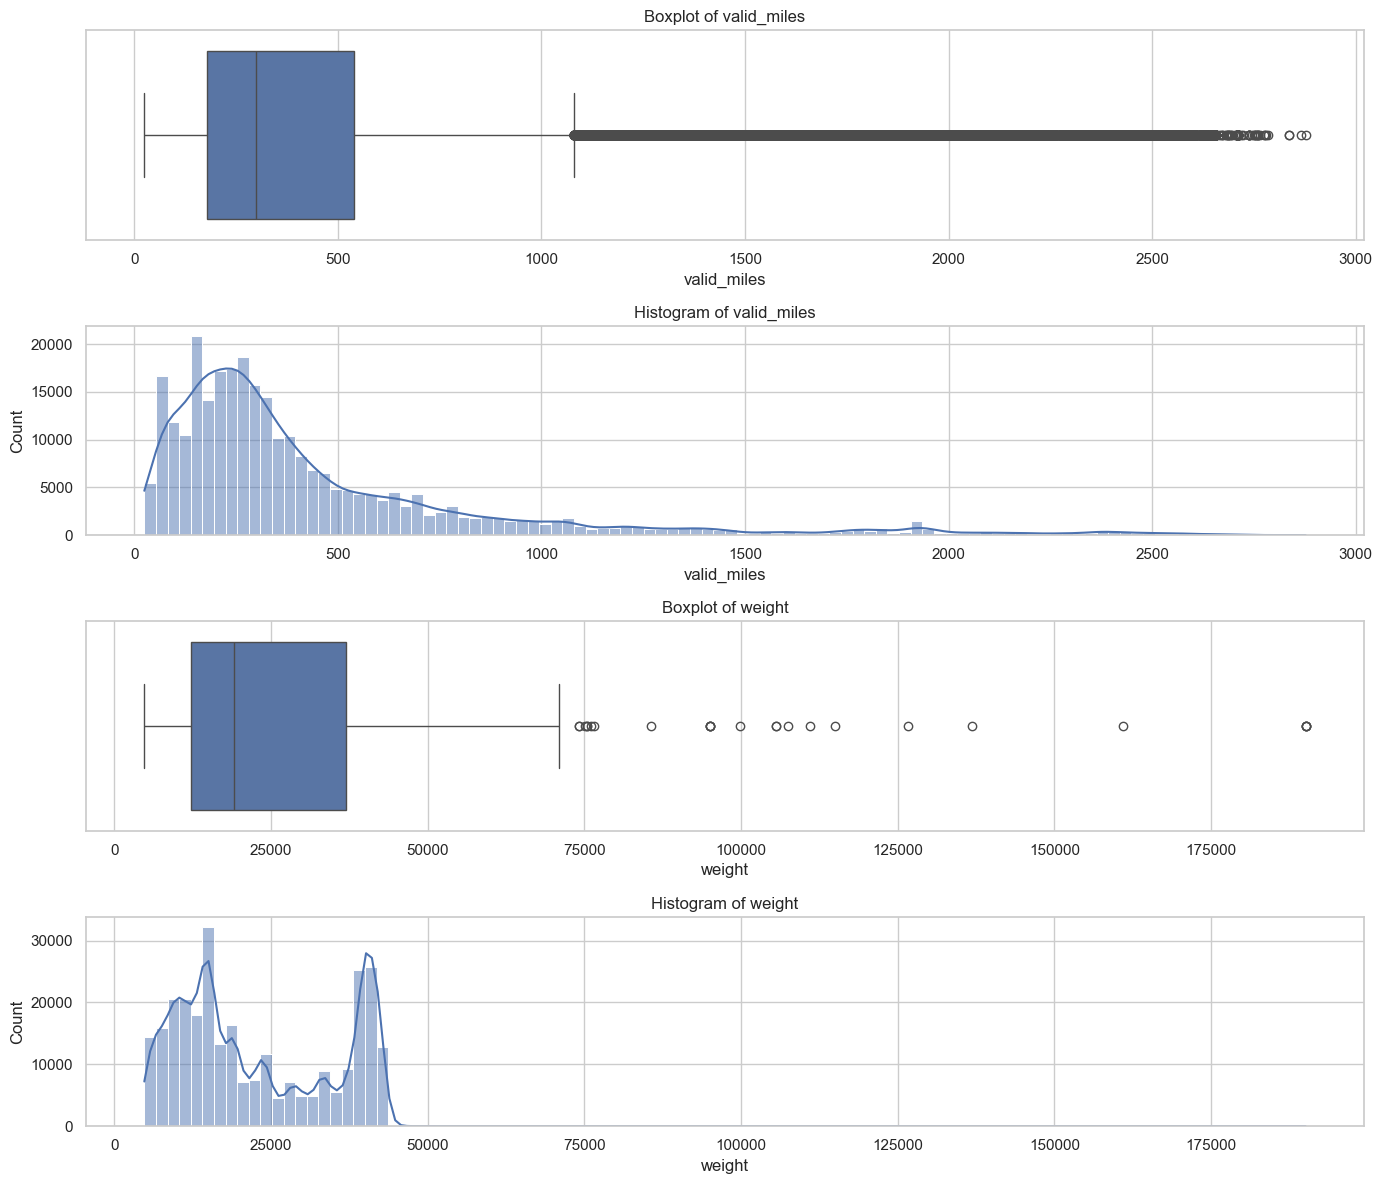

In [29]:
analyze_outliers_valid_miles_weight(train_df)

1. **Средний rate по origin_kma и destination_kma**
- Есть значительный разброс средних значений rate в зависимости от KMA.
- Некоторые KMA имеют стабильно высокий rate, что может быть связано с удаленностью, сложностью маршрута или рыночными условиями.
- Графики подтверждают, что KMA влияет на стоимость перевозки.

2. **Boxplot по transport_type**
- Видно, что выбросы присутствуют во всех трех типах транспорта.
- Основные значения rate не сильно различаются между транспортными типами, но для некоторых категорий встречаются экстремально высокие rate.
- Возможно, определенные transport_type имеют скрытые факторы, влияющие на rate.
3. **Scatter plot: rate vs valid_miles и rate vs weight**
- Чем выше valid_miles, тем ниже rate, что соответствует логике (цена за милю снижается при длинных маршрутах).
- Выбросы встречаются в основном на коротких дистанциях.
- График по weight показывает, что тяжелые грузы не всегда коррелируют с высоким rate, но есть выбросы в низких значениях веса.

4. **Boxplot по праздничным дням**
- В праздничные дни rate может быть ниже, но данных мало, чтобы делать окончательный вывод.
- Выбросы присутствуют и в обычные дни, и в праздничные, но в праздники меньше значений с экстремальными тарифами.
5. **Распределение rate до и после логарифмирования**
- Оригинальное распределение сильно скошено вправо.
- Логарифмирование делает данные более нормальными, что улучшит модель, но нельзя забывать, что log(0) не определен.
6. **Топ-10 KMA с самым высоким и низким rate**
- Определенные KMA стабильно имеют самые высокие и низкие rate.
- Возможно, в этих регионах есть особенности транспортного рынка (доступность, сложность маршрута и т.д.).
- Эти KMA можно дополнительно исследовать, чтобы понять причины расхождений.

## Сравнение метрик rate, valid_miles, weight до и после удаления выбросов

In [30]:
def compare_outliers_impact(df):
    cols = ["rate", "valid_miles", "weight"]
    stats_before = df[cols].describe()

    # Удаляем выбросы по IQR
    df_filtered = df[
        (detect_outliers_iqr(df, "rate") == False) &
        (detect_outliers_iqr(df, "valid_miles") == False) &
        (detect_outliers_iqr(df, "weight") == False)
    ]

    stats_after = df_filtered[cols].describe()

    for col in cols:
        print(f"\n=== {col.upper()} ===")
        print("До удаления выбросов:")
        print(stats_before[col])
        print("\nПосле удаления выбросов:")
        print(stats_after[col])

In [31]:
compare_outliers_impact(train_df)


=== RATE ===
До удаления выбросов:
count    286267.000000
mean          5.239575
std           2.983215
min           1.288400
25%           3.529500
50%           4.595000
75%           6.041300
max         248.973000
Name: rate, dtype: float64

После удаления выбросов:
count    248105.000000
mean          4.909064
std           1.743098
min           1.288400
25%           3.627900
50%           4.622300
75%           5.856200
max           9.808700
Name: rate, dtype: float64

=== VALID_MILES ===
До удаления выбросов:
count    286267.000000
mean        450.479197
std         447.906249
min          24.780100
25%         179.123900
50%         298.375000
75%         539.173400
max        2876.446900
Name: valid_miles, dtype: float64

После удаления выбросов:
count    248105.000000
mean        356.676283
std         229.311923
min          30.218000
25%         189.510200
50%         289.742000
75%         458.664000
max        1078.905000
Name: valid_miles, dtype: float64

=== WEIGHT

## Сравнение распределения rate, valid_miles, weight до и после логарифмирования

In [32]:
def analyze_log_transformation(df):
    fig, axes = plt.subplots(6, 1, figsize=(10, 30))

    for i, col in enumerate(["rate", "valid_miles", "weight"]):
        # Оригинальное распределение
        sns.histplot(df[col], bins=100, kde=True, ax=axes[i * 2])
        axes[i * 2].set_title(f"Original distribution of {col}")

        # Логарифмированное распределение
        sns.histplot(np.log1p(df[col]), bins=100, kde=True, ax=axes[i * 2 + 1])
        axes[i * 2 + 1].set_title(f"Log-transformed distribution of {col}")

    plt.tight_layout()
    plt.show()

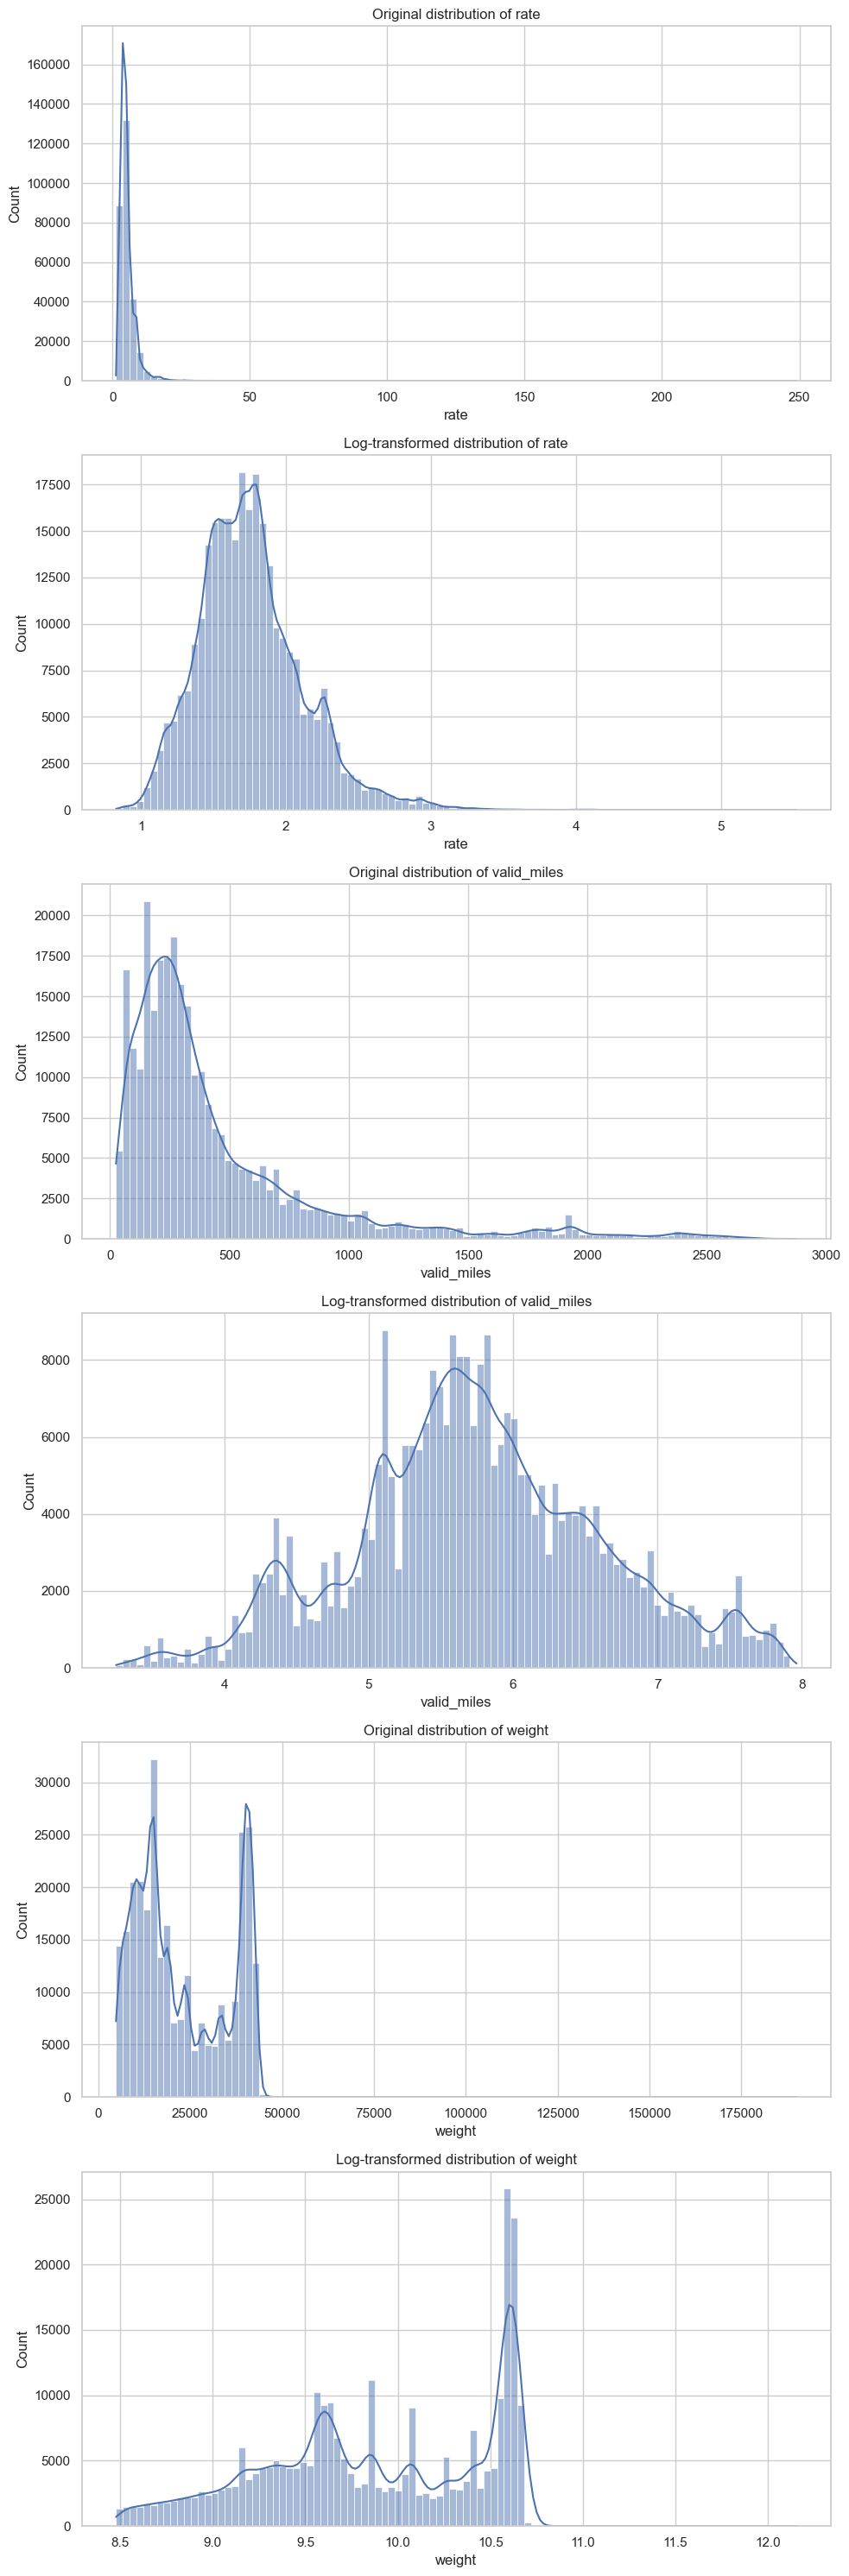

In [33]:
analyze_log_transformation(train_df)

## Анализ выбросов rate по transport_type

In [34]:
def analyze_rate_by_transport_type(df):
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # Boxplot
    sns.boxplot(x=df["transport_type"], y=df["rate"], ax=axes[0])
    axes[0].set_title("Boxplot of rate by transport_type")

    # KDE-график
    for transport in df["transport_type"].unique():
        sns.kdeplot(df[df["transport_type"] == transport]["rate"], label=transport, ax=axes[1])
    axes[1].set_title("KDE of rate by transport_type")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

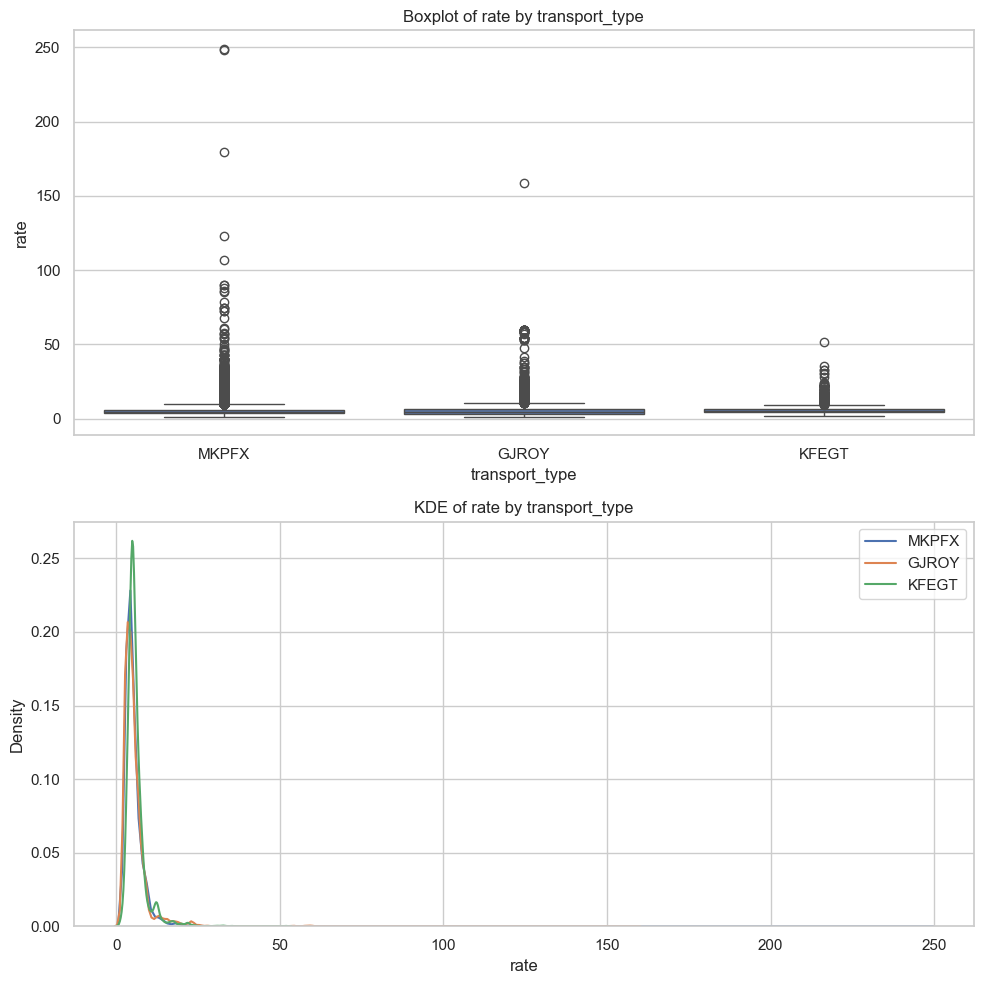

In [35]:
analyze_rate_by_transport_type(train_df)

**1. Heatmap зависимости rate от сочетания origin_kma → destination_kma**
- Видно, что есть редкие сочетания KMA с аномально высокими значениями rate.
- В большинстве случаев rate распределен равномерно, но есть отдельные выбросы.
- Это подтверждает гипотезу, что сочетание KMA (а не только origin_kma или destination_kma по отдельности) влияет на rate.
- Требуется более детальный анализ топ-аномальных сочетаний.

**2. Boxplot и гистограмма valid_miles и weight**
- **valid_miles**: Есть длинные хвосты, выбросы выше 1500 миль.
- **weight**: Два отчетливых пика, один ближе к 20-30 тысячам, другой выше 50 тысяч.
- Оба признака требуют логарифмирования или фильтрации выбросов.

**3. Распределение rate, valid_miles, weight до и после логарифмирования**
- Логарифмирование сглаживает распределения, делая их более нормальными.
- valid_miles и weight после логарифмирования стали ближе к нормальному распределению.
- rate после логарифмирования стал лучше структурированным, но все еще есть хвост.

**4. Boxplot и KDE rate по transport_type**
- Большинство значений rate сгруппированы в узком диапазоне, но выбросы существенны.
- KDE показывает, что распределение rate для всех транспортных типов схожее.
- transport_type не является основным фактором, определяющим выбросы.

## Heatmap выбросов rate (не среднего, а аномальных значений) по KMA

In [36]:
def plot_outlier_heatmap(df, column="rate"):
    """
    Построить heatmap частоты выбросов rate по парам (origin_kma, destination_kma).
    """
    outliers = detect_outliers_iqr(df, column)  # Используем IQR для детекции выбросов
    outlier_counts = df.loc[outliers].groupby(["origin_kma", "destination_kma"])[column].count().unstack(fill_value=0)

    plt.figure(figsize=(14, 12))
    sns.heatmap(outlier_counts, cmap="coolwarm", linewidths=0.5)
    plt.title(f"Frequency of {column} Outliers by Origin-Destination KMA")
    plt.xlabel("Destination KMA")
    plt.ylabel("Origin KMA")
    plt.show()

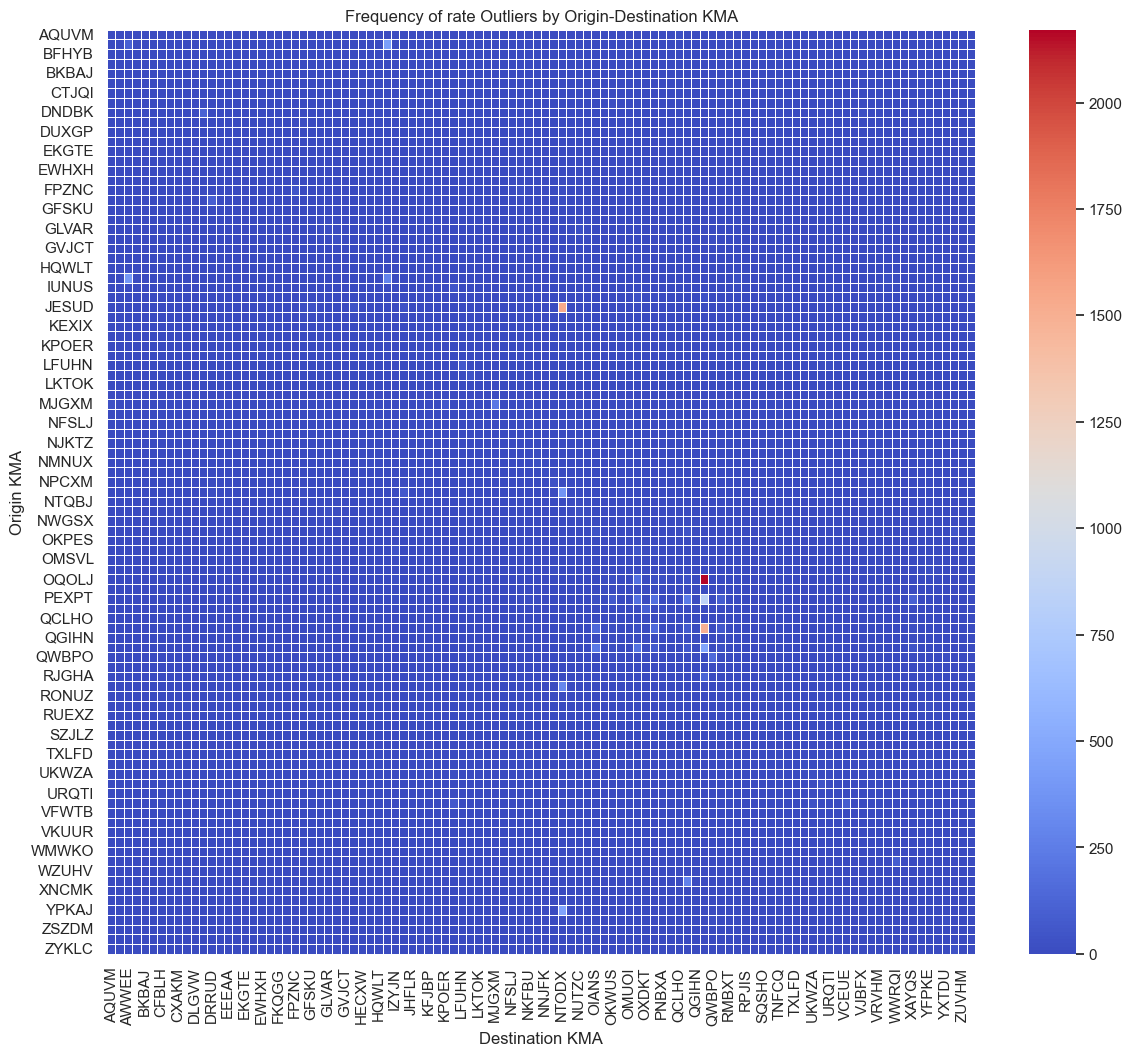

In [37]:
plot_outlier_heatmap(train_df, "rate")

## Анализ связи transport_type с valid_miles и weight

In [38]:
def plot_transport_vs_features(df):
    """
    Проверить, как transport_type влияет на valid_miles и weight.
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    sns.boxplot(x="transport_type", y="valid_miles", data=df, ax=axes[0])
    axes[0].set_title("Valid Miles by Transport Type")

    sns.boxplot(x="transport_type", y="weight", data=df, ax=axes[1])
    axes[1].set_title("Weight by Transport Type")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

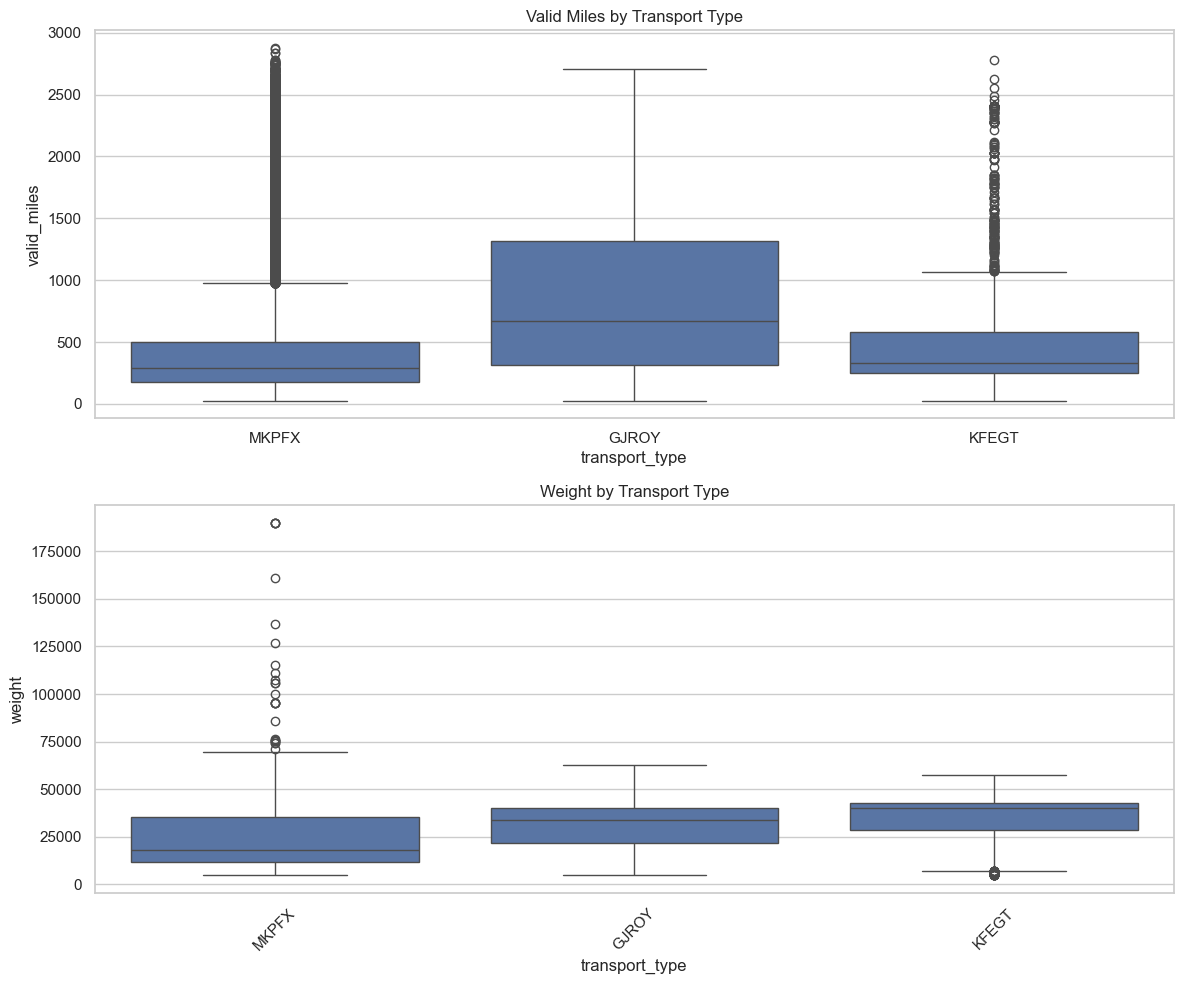

In [39]:
plot_transport_vs_features(train_df)

## Выявление локальных пиков rate во времени

In [40]:
def plot_rolling_rate(df, window=90):
    """
    Построить rolling mean по rate, чтобы увидеть локальные тренды.
    """
    df = df.sort_values("pickup_date")
    df["rolling_mean_rate"] = df["rate"].rolling(window=window, min_periods=1).mean()

    plt.figure(figsize=(12, 5))
    plt.plot(df["pickup_date"], df["rolling_mean_rate"], color="red", label=f"{window}-Day Rolling Mean")
    plt.scatter(df["pickup_date"], df["rate"], alpha=0.1, label="Raw Data", s=10)
    plt.title(f"Rolling Mean Analysis of Rate ({window} days)")
    plt.xlabel("Date")
    plt.ylabel("Rate")
    plt.legend()
    plt.show()

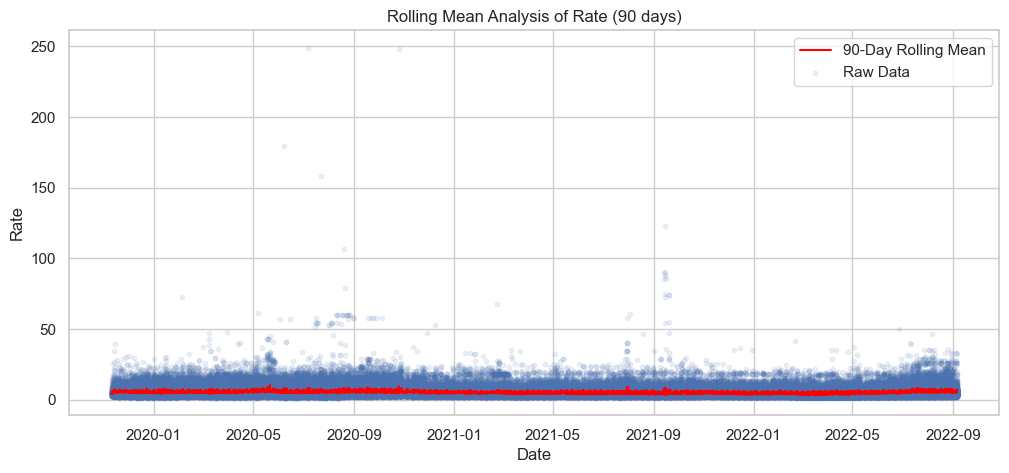

In [41]:
plot_rolling_rate(train_df)


**1. Rolling Mean Analysis of Rate (90 days)**
- Скользящее среднее показывает стабильность `rate` без явных трендов.
- Видны редкие выбросы, но долгосрочные колебания минимальны.
- Глобального роста или спада `rate` не наблюдается.

**2. Valid Miles and Weight by Transport Type**
- `valid_miles` варьируются в зависимости от `transport_type`, особенно заметны отличия у `GJROY` (более длинные маршруты).
- `weight` также распределяется неравномерно, но различия между транспортами менее выражены.
- Выбросы в `valid_miles` есть во всех категориях, но `MKPFX` и `KFEGT` имеют более компактное распределение.

 **3. Frequency of Rate Outliers by Origin-Destination KMA**
- Выбросы в `rate` сконцентрированы в небольшом количестве `origin-destination` пар.
- Большая часть значений `rate` остается в пределах нормы.
- Есть несколько сильно выделяющихся точек с аномально высокими значениями.

## Rate vs. Log Rate

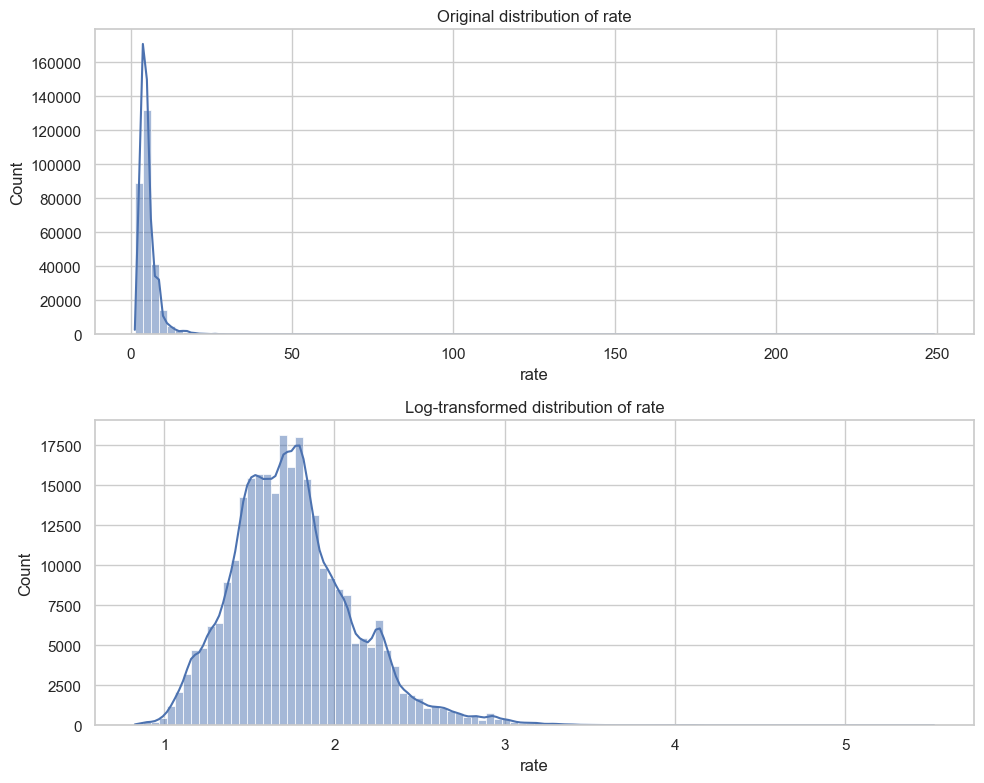

In [42]:
check_log_transform(train_df, "rate")

## Добавить логарифм rate

In [43]:
train_df['log_rate'] = np.log1p(train_df['rate'])  # log1p для защиты от log(0)

## корреляции для `rate` и `log(rate)`

In [44]:
features = ["valid_miles", "log_valid_miles", "weight", "log_weight", 
            "origin_kma_mean_rate", "destination_kma_mean_rate"]

In [45]:
correlation_rate = train_df[["rate"] + features].corr()["rate"]
correlation_log_rate = train_df[["log_rate"] + features].corr()["log_rate"]

In [46]:
correlation_df = pd.DataFrame({
    "Rate": correlation_rate,
    "Log(Rate)": correlation_log_rate
}).drop(index=["rate", "log_rate"])

In [47]:
print("Корреляция Rate:")
print(correlation_rate)
print("\nКорреляция Log(Rate):")
print(correlation_log_rate)

Корреляция Rate:
rate                         1.000000
valid_miles                 -0.394266
log_valid_miles             -0.652184
weight                      -0.074483
log_weight                  -0.070949
origin_kma_mean_rate         0.442869
destination_kma_mean_rate    0.412774
Name: rate, dtype: float64

Корреляция Log(Rate):
log_rate                     1.000000
valid_miles                 -0.492243
log_valid_miles             -0.728619
weight                      -0.113635
log_weight                  -0.103637
origin_kma_mean_rate         0.494201
destination_kma_mean_rate    0.499627
Name: log_rate, dtype: float64


In [48]:
if correlation_log_rate.abs().mean() > correlation_rate.abs().mean():
    print("Log(Rate) показывает более сильные корреляции. Логарифмирование оправдано.")
else:
    print("Логарифмирование не дает значительного улучшения. Используем исходный Rate.")

Log(Rate) показывает более сильные корреляции. Логарифмирование оправдано.


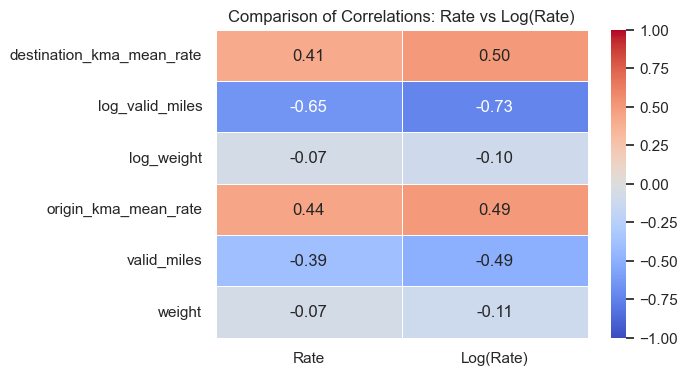

In [51]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    correlation_df, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    vmin=-1, vmax=1  # Fixing scale from -1 to 1
)
plt.title("Comparison of Correlations: Rate vs Log(Rate)" 
          if "Log(Rate)" in correlation_df.columns else "Correlation of Rate")
plt.show()

## Проверка линейности зависимостей (scatter plots)

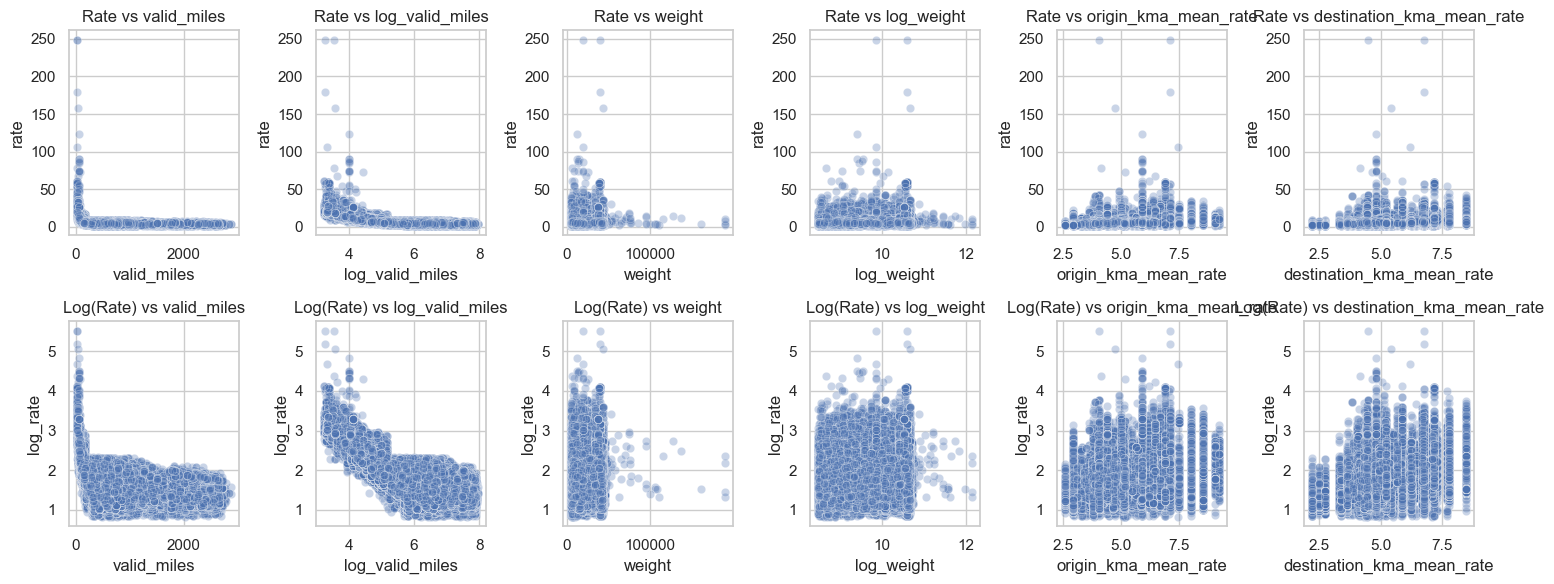

In [52]:
fig, axes = plt.subplots(2, len(features), figsize=(15, 6))
for i, feature in enumerate(features):
    # Обычный rate
    sns.scatterplot(x=train_df[feature], y=train_df["rate"], ax=axes[0, i], alpha=0.3)
    axes[0, i].set_title(f"Rate vs {feature}")
    
    # Логарифмированный rate
    sns.scatterplot(x=train_df[feature], y=train_df["log_rate"], ax=axes[1, i], alpha=0.3)
    axes[1, i].set_title(f"Log(Rate) vs {feature}")

plt.tight_layout()
plt.show()

- Корреляционный анализ:
    - Корреляция признаков с rate показала:
        - valid_miles и log_valid_miles имеют сильную отрицательную корреляцию, особенно в логарифмированном варианте (-0.73 для log_valid_miles).
        - origin_kma_mean_rate и destination_kma_mean_rate положительно коррелируют с rate, причем корреляция усиливается после логарифмирования (до 0.49 и 0.50 соответственно).
        - destination_kma_mean_rate показывает чуть более сильную корреляцию с log_rate, чем origin_kma_mean_rate, что указывает на большую значимость точки назначения.
        - weight и log_weight имеют слабую отрицательную корреляцию, но после логарифмирования она слегка усиливается (-0.11 для log_weight).
    - Логарифмирование не только увеличивает корреляции, но и делает распределение признаков более равномерным, что полезно для линейных моделей.
    - log_valid_miles лучше описывает зависимость от логарифмированного целевого признака, чем исходный valid_miles.
- Сравнение Rate vs Log(Rate):
    - Логарифмирование rate увеличило корреляции с valid_miles, origin_kma_mean_rate и destination_kma_mean_rate, делая его более подходящим для модели.
    - Логарифмирование помогает устранить экспоненциальные зависимости и стабилизировать дисперсию.
    - log_rate становится лучшей целевой переменной для моделей, чувствительных к распределению данных (например, линейных регрессий).
- Графический анализ:
    - rate vs valid_miles показывает сильную экспоненциальную зависимость, что подтверждает необходимость логарифмирования.
    - rate vs weight демонстрирует хаотичное распределение, и после логарифмирования ситуация улучшается, но незначительно.
    - origin_kma_mean_rate и destination_kma_mean_rate имеют относительно устойчивую положительную связь с rate.
    - На scatter plot видны выбросы (особенно для rate и weight), которые могут искажать корреляции и влиять на модель. Нужно рассмотреть вариант их устранения или трансформации.


- Выводы по логарифмированию:
    - log_valid_miles и log_rate должны использоваться в модели, так как они усиливают линейные зависимости и улучшают корреляции.
    - Логарифмирование weight улучшает корреляции незначительно, но может помочь уменьшить влияние выбросов в линейных моделях.
    - Для моделей типа деревьев логарифмирование weight может быть не критичным, но для линейных регрессий логарифмированные значения предпочтительнее.
- Общие выводы:
    - Использовать log_rate в качестве целевой переменной.
    - Включить log_valid_miles и log_weight как дополнительные признаки.
    - Рассмотреть очистку данных от выбросов, чтобы улучшить качество модели.